# Exploring Goodreads data
This notebook explores the data collected from Goodreads on a large number of books and looks at the various attributes to frame a problem statement at the end to work on.

## 1. Environment Setup
Importing all the required packages:-
- langdetect: helps detect language in any unicode string. We use this to detect the language of the book
- cufflinks: cufflinks makes plotting with Pandas and Plotly a lot easier.

In [ ]:
!pip install langdetect -q
from langdetect import detect

import string
valid_chars=string.ascii_letters+string.digits+' '

import pandas as pd
import numpy as np

import cufflinks as cf
cf.go_offline()
from collections import defaultdict

from google.colab import files

def configure_plotly_browser_state():
    #This function is required to see Plotly charts in colab. Call this function in every cell where a Plotly chart gets drawn.
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.43.1.min.js?noext',
            },
          });
        </script>
        '''))

## 2. Kaggle setup
I have used the available GoodReads data set in Kaggle which can be found [here](https://www.kaggle.com/meetnaren/goodreads-best-books) and [here](https://www.kaggle.com/meetnaren/goodreads-best-books-of-2018). The two cells below make use of the Kaggle API to download the data and unzip to be used for our analysis. Upload your 'kaggle.json' to use kaggle on colab.

In [ ]:
!pip install kaggle --upgrade -q
files.upload()

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!mkdir train
!mkdir test

!kaggle datasets download -d meetnaren/goodreads-best-books -p train
!kaggle datasets download -d meetnaren/goodreads-best-books-of-2018 -p test

!unzip train/goodreads-best-books.zip -d train
!unzip test/goodreads-best-books-of-2018.zip -d test

book_data_train=pd.read_csv('train/book_data.csv')
book_data_test=pd.read_csv('test/book_data.csv')

In [ ]:
book_data_train.head()

book_authors  ...                                          image_url
0                                    Suzanne Collins  ...  https://images.gr-assets.com/books/1447303603l...
1                         J.K. Rowling|Mary GrandPré  ...  https://images.gr-assets.com/books/1255614970l...
2                                         Harper Lee  ...  https://images.gr-assets.com/books/1361975680l...
3  Jane Austen|Anna Quindlen|Mrs. Oliphant|George...  ...  https://images.gr-assets.com/books/1320399351l...
4                                    Stephenie Meyer  ...  https://images.gr-assets.com/books/1361039443l...

[5 rows x 12 columns]

## 3. Exploring genres
Here I explored the genres of the books.
There are multiple genres that a book can belong to, e.g., a detective novel can belong to fiction, mystery, thriller, etc. I plotted the number of genres as a histogram to see the distribution. 

In [ ]:
configure_plotly_browser_state()

def genre_count(genres):
    '''
    Returns the number of genres in the genre column of the dataframe
    Input: genre data
    Output: no. of genres
    '''
    try:
        return len(genres.split('|'))
    except:
        return 0


book_data_train['num_genres'] = book_data_train['genres'].apply(genre_count)
book_data_train['num_genres'].iplot(kind='histogram', xTitle='No. of genres', yTitle='Count', gridcolor='rgba(0,0,0,0)')

On average, we could see that books are tagged with around 5-6 genres. Let us now see how many unique genres are available and the counts.

In [ ]:
genre_counts=defaultdict(int)
for i in book_data_train.index:
    g=book_data_train.at[i, 'genres']
    if type(g)==str:
        for j in g.split('|'):
            genre_counts[j]+=1

print(len(genre_counts))

866


There's a whopping 866 unique genres in the data collected! While it may not be worth looking at each and every genre, let's take a look at the top genres.

In [ ]:
configure_plotly_browser_state()
genre_counts_df=pd.DataFrame.from_records(sorted(genre_counts.items(), key=lambda x:x[1], reverse=True), columns=['genre', 'count'])
genre_counts_df[:50].iplot(
    kind='bar', 
    x='genre', 
    y='count',
    margin={
        'b':175
    },
    gridcolor='rgba(0,0,0,0)'
)

There seems to be quite a long tail of genres even in the top 50 list. Interestingly, the number of nonfiction books is quite low (~7.5K) compared to fiction (~26K).

## 4. Exploring book covers
Let us take a look at some of the book covers that we have collected to see if there are any discernible patterns mapping them to their respective genres.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from os.path import exists

def plot_book_covers(n):
    '''
    Prints a specified no. of book covers and their corresponding genres. Helps to examine if there is any pattern in the book covers
    Input: no. of book covers to display
    Output: None
    '''
    indices=list(np.random.randint(min(book_data_train.index), max(book_data_train.index), size=n))
    fig=plt.figure(figsize=(n*5, 10))
    for i in indices:
        if exists(f'train/images/images/{i}.jpg'):
            ax = fig.add_subplot(2, n, (indices.index(i)+1), xticks=[], yticks=[])
            ax.imshow(Image.open(f'train/images/images/{i}.jpg'))
            ax = fig.add_subplot(2, n, (indices.index(i)+1)+n, xticks=[], yticks=[])
            if type(book_data_train.at[i, 'genres'])==str:
                t='\n'.join(book_data_train.at[i, 'genres'].split('|'))
            else:
                t=''
            ax.text(0.5, 0.5, t, fontsize=15, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

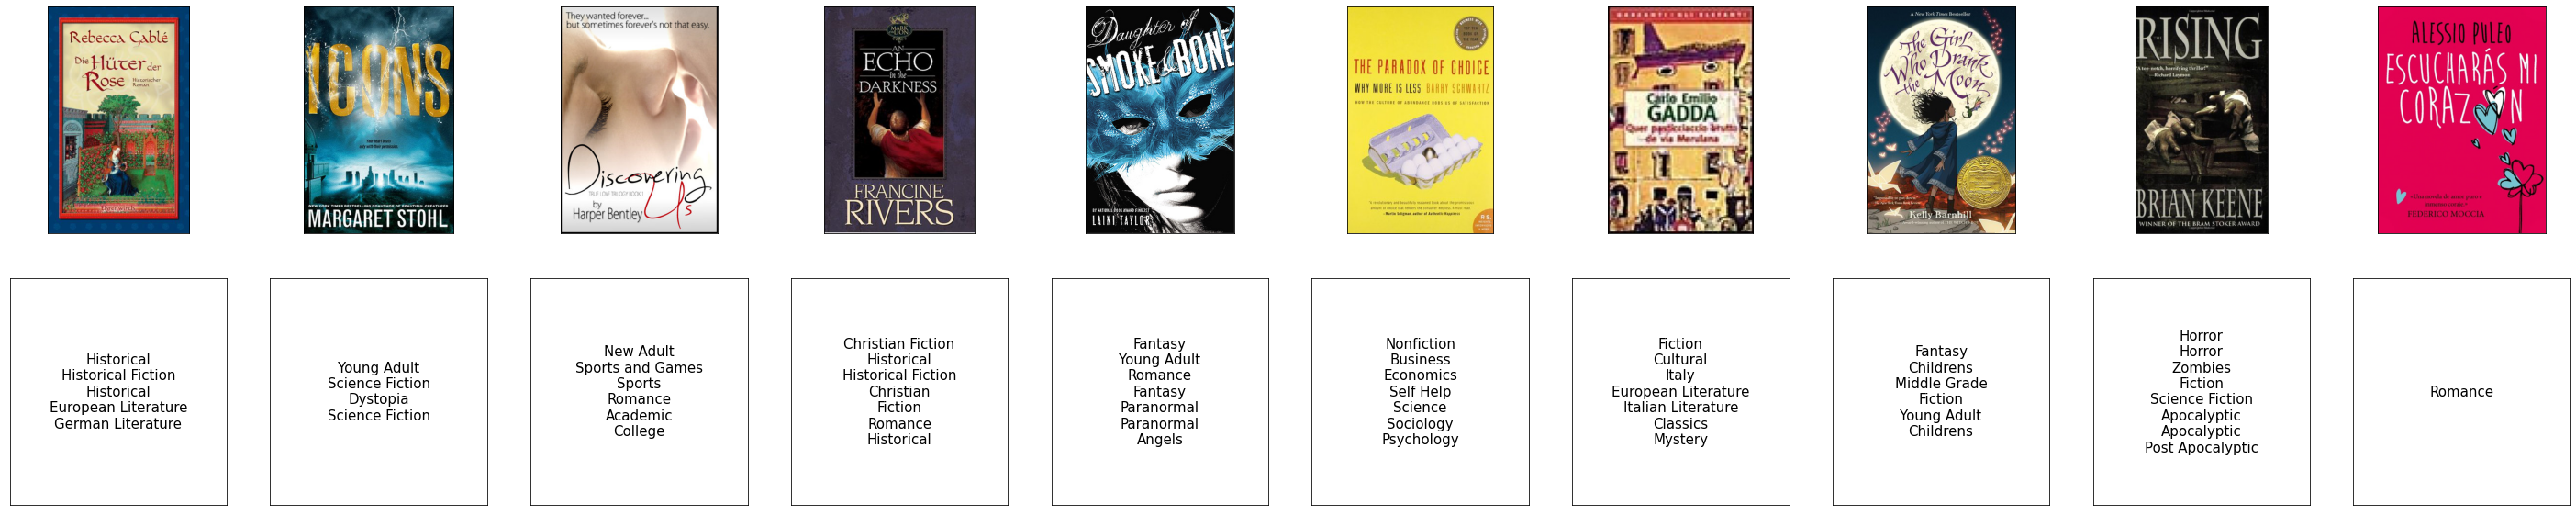

In [ ]:
plot_book_covers(10)

We can observe that some of them seem to have random photos that don't have anything to do with the book title or genres. 

## 5. Exploring authors
Some of the books seem to have multiple authors. Similar to genres, i took a look at the number of authors for each book.

In [ ]:
book_data_train['num_authors']=book_data_train['book_authors'].str.split('|').apply(len)
configure_plotly_browser_state()
book_data_train['num_authors'].iplot(kind='histogram', xTitle='No. of authors', yTitle='Count', gridcolor='rgba(0,0,0,0)')

A majority of the books seem to have just one author, we do seem to have some that have more than 10 authors (even 50, in some cases). 

In [ ]:
book_data_train[book_data_train['num_authors']>10].head()

book_authors  ... num_authors
513   P.D. Eastman|Merwin Goldsmith|MARIAN HAILEY|Ro...  ...          11
2078  Neil Gaiman|Mike Dringenberg|Chris Bachalo|Mic...  ...          15
3207  Plato|Benjamin Jowett|John M. Cooper|Dorothea ...  ...          35
3322  Neil Gaiman|Marc Hempel|Richard Case|D'Israeli...  ...          11
3475  Neil Gaiman|Jill Thompson|Vince Locke|Bryan Ta...  ...          21

[5 rows x 14 columns]

Upon researching these books, it seems that most of them are either illustrated books for children or collections of short stories. In the case of illustrated books, there are multiple illustrators, each of whom is listed as an author. And in the case of collections of short stories, the author of each short story is also listed as the author.

## 6. Exploring languages
One of the first things I noticed in the dataset was that there are books of various languages available in the list. If I need to run an experiment on the text of the book's description, I will need to make sure that they are all from the same language.

Let us look at the various languages available in the dataset.

In [ ]:
def remove_invalid(df):
    '''
    Removes records that have invalid descriptions from the dataframe
    Input: dataframe
    Output: Cleaned up dataframe'''
  
    invalid_desc_idxs=[]
    for i in df.index:
        try:
            a=detect(df.at[i,'book_desc'])
        except:
            invalid_desc_idxs.append(i)
    
    df=df.drop(index=invalid_desc_idxs)
    return df

book_data_train=remove_invalid(book_data_train)
book_data_train['lang']=book_data_train.book_desc.apply(detect)

#Downloading the list of languages to map the two-letter lang code to the language name
lang_lookup=pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes')[1]
#lang_lookup.drop([0], inplace=True)
#lang_lookup.columns=lang_lookup.iloc[0]
#lang_lookup=lang_lookup.reindex(lang_lookup.index)
lang_lookup.rename(columns={'639-1': 'lang'}, inplace=True)
#lang_lookup

def get_language(lang):
    if lang in list(lang_lookup['lang']):
        return lang_lookup[lang_lookup['lang']==lang]['ISO language name'].values[0]
    else:
        return 'N/A'

#get_language('ak')
book_data_train['language']=book_data_train['lang'].apply(get_language)

In [ ]:
configure_plotly_browser_state()
group_by_lang=book_data_train.groupby(['language'])['book_title'].count().reset_index().sort_values(by=['book_title'], ascending=False)
group_by_lang.iplot(
    kind='bar', 
    x='language', 
    y='book_title',
    margin={
        'b':200
    },
    gridcolor='rgba(0,0,0,0)'
)

English constitutes almost 90% of the books, though. I removed English from the chart to see the distribution better.

In [ ]:
configure_plotly_browser_state()
group_by_lang[group_by_lang['language']!='English'].iplot(
    kind='bar', 
    x='language', 
    y='book_title',
    margin={
        'b':210
    },
    gridcolor='rgba(0,0,0,0)'
)

Out of curiosity, let me take a look at the books in Hindi (which is my mother tongue).

In [ ]:
book_data_train[book_data_train['language']=='Hindi']

book_authors  ... language
11036                 Dharamvir Bharati  ...    Hindi
24175                   Krishan Chander  ...    Hindi
29907  Harishankar Parsai|हरिशंकर परसाई  ...    Hindi
45996         Bhisham Sahni|भीष्म साहनी  ...    Hindi

[4 rows x 16 columns]

## 7. Data Cleaning
First I wanted to do an analysis of book covers to examine if the genres can be deduced from the pictures. But there are two issues:
1. The book covers dont seem to convey a lot of information about the genres of the books themselves
2. The genres seem to be very high in number and non-standard

I think deducing the genre of the book from its description seems to be a better problem statement. Although it's a trivial task, building a RNN model around it can definitely be helpful in learning how to structure data to be fed into a neural network. It will also need a bit of data cleaning as we saw above.
So I did that.

In [ ]:
def genre_binarizer(genres):
    '''
    Analyzes the genres string passed as argument to check if fiction or nonfiction is present and returns a genre appropriately
    Inputs: the genres column data from the book data frame
    Returns:
    - fiction, if fiction is present
    - nonfiction, if nonfiction is present
    - neither, if neither is present
    '''
    genre_list=genres.lower().split('|')
    if 'fiction' in genre_list:
        return 'fiction'
    elif 'nonfiction' in genre_list:
        return 'nonfiction'
    else:
        return 'neither'

def eng_desc(df):
    '''
    Analyzes the book description in the data frame passed, and returns a data frame with non-English records removed using the langdetect package
    Inputs: data frame
    Returns: data frame with non-English description records removed
    '''
    invalid_desc_idxs=[]
    for i in df.index:
        try:
            a=detect(df.at[i,'book_desc'])
        except:
            invalid_desc_idxs.append(i)
    
    if len(invalid_desc_idxs)>0:
        print('Removing these records as the descriptions are invalid:',invalid_desc_idxs)
    df=df.drop(index=invalid_desc_idxs)
    df['lang']=df.book_desc.apply(detect)
    df=df[df.lang=='en']
    return df

def add_space_case(desc):
    '''
    Analyzes the book description passed and inserts spaces where a lowercase letter is followed immediately by an uppercase letter.
    Inputs: book description
    Returns: Modified book description
    '''
    upd_desc=''
    
    for i in range(len(desc)-1):
        upd_desc+=desc[i]
        if desc[i] in string.ascii_lowercase and desc[i+1] in string.ascii_uppercase:
            upd_desc+=' '
    
    upd_desc+=desc[-1]
    return upd_desc  

def remove_punctuation(desc):
    '''
    Modifies the book description passed to 
    - insert spaces in place of punctuations
    - join apostrophe words to their parent words and 
    - insert spaces where lowercase is followed by uppercase
    Inputs: book description
    Returns: modified book description
    '''
    desc=add_space_case(desc)
    apostrophe_words=['m', 're', 've', 'll', 't', 's', 'd']
    
    desc=desc.lower()
        
    desc=''.join([c if c in valid_chars else ' ' for c in desc])
    
    for a in apostrophe_words:
        desc=desc.replace(' '+a+' ', a+' ')

    return desc

        
def df_cleaner(df):
    '''
    Takes in a dataframe and performs the following steps to clean up:
    - Removes records with null genres and descriptions
    - Removes records where genre is neither fiction nor nonfiction
    - Removes records where the description is non-English
    - Removes punctuations from the description
    - Resets the index
    Inputs: dataframe
    Returns: cleaned-up dataframe
    '''
    print("No. of records            :", len(df))
    
    df=df[df.genres.notnull()]
    print("After removing null genres:", len(df))
    
    df=df[df.book_desc.notnull()]
    print("After removing null descs :", len(df))
    
    df=df[df.book_desc.str.strip().apply(len)>0]
    print("After removing zero descs :", len(df))
    
    df['binary_genre']=df.genres.apply(genre_binarizer)
    df=df[df.binary_genre!='neither']
    print("Only fiction or nonfiction:", len(df))
    
    df=eng_desc(df)
    print("After removing non-English:", len(df))
    
    df['clean_desc']=df.book_desc.apply(remove_punctuation)
    
    df.reset_index(drop=True, inplace=True)
    print('---------------------------')
    return df
    
book_data_train=df_cleaner(book_data_train)
book_data_test=df_cleaner(book_data_test)

No. of records            : 52961
After removing null genres: 50172
After removing null descs : 50172
After removing zero descs : 50172
Only fiction or nonfiction: 33330
After removing non-English: 29338
---------------------------
No. of records            : 1141
After removing null genres: 1130
After removing null descs : 1126
After removing zero descs : 1126
Only fiction or nonfiction: 661
After removing non-English: 657
---------------------------
